# Neural Survival Clustering on SUPPORT Dataset

The SUPPORT dataset comes from the Vanderbilt University study
to estimate survival for seriously ill hospitalized adults.
(Refer to http://biostat.mc.vanderbilt.edu/wiki/Main/SupportDesc.
for the original datasource.)

In this notebook, we will apply Neural Survival Clustering on the SUPPORT data.

In [44]:
import sys
sys.path.append('../')
# sys.path.append('../DeepSurvivalMachines/')

### Load the SUPPORT Dataset

The package includes helper functions to load the dataset.

X represents an np.array of features (covariates),
T is the event/censoring times and,
E is the censoring indicator.

In [45]:
from nsc import datasets
x, t, e = datasets.load_dataset('SUPPORT')

In [46]:
import pandas as pd
df = pd.concat([pd.DataFrame(x), pd.DataFrame(t), pd.DataFrame(e)], axis=1)
df

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,0,0
0,0.012772,-1.390013,0.449837,-6.931821e-01,-0.892283,-0.138967,-0.881504,1.569019e+00,-1.655686e+00,-5.238337e-01,...,-0.093555,-0.424643,-0.181379,8.960728,-1.938312,1.974951,-1.388399,-0.399286,2029,0
1,-0.148262,0.097711,-1.500702,5.187096e-01,0.470382,1.114591,-2.005013,-1.495658e+00,-6.389701e-16,9.880260e-17,...,-0.093555,-0.424643,-0.181379,-0.111598,0.515913,-0.506342,0.720254,-0.399286,4,1
2,-0.635153,0.097711,-0.525432,-4.201759e-01,-0.290175,0.487812,0.235766,-8.319880e-02,-6.389701e-16,-7.892740e-02,...,-0.093555,-0.424643,-0.181379,-0.111598,0.515913,-0.506342,0.720254,-0.399286,47,1
3,-1.299688,0.097711,-0.344827,-3.546971e-01,-0.290175,0.905665,-1.680444,-3.003564e-16,-6.389701e-16,9.880260e-17,...,-0.093555,-0.424643,-0.181379,-0.111598,0.515913,1.974951,-1.388399,-0.399286,133,1
4,1.105258,-0.646151,-0.922764,1.258366e-01,0.470382,-0.347893,0.635237,-6.997670e-01,-6.389701e-16,9.880260e-17,...,-0.093555,-0.424643,-0.181379,-0.111598,0.515913,-0.506342,0.720254,-0.399286,2029,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9100,0.219471,-0.646151,0.883291,-5.403626e-01,0.216863,-0.138967,-1.124933,4.276908e-01,1.077955e+00,-4.793410e-01,...,-0.093555,-0.424643,-0.181379,-0.111598,0.515913,-0.506342,0.720254,-0.399286,350,0
9101,-0.480786,-0.646151,-1.500702,1.939826e-16,-3.078884,-1.601451,1.190748,-2.222321e-01,-6.389701e-16,9.880260e-17,...,-0.093555,-0.424643,-0.181379,-0.111598,0.515913,-0.506342,0.720254,-0.399286,347,0
9102,0.495813,-0.646151,0.955533,-4.312668e-01,-0.448624,0.069960,-0.325992,-6.290945e-01,-6.389701e-16,-4.793410e-01,...,-0.093555,-0.424643,-0.181379,-0.111598,0.515913,-0.506342,0.720254,-0.399286,346,0
9103,-1.002436,-0.646151,0.522080,-5.185008e-01,0.407002,0.069960,-0.563174,1.997678e+00,-2.518775e+00,-4.793410e-01,...,-0.093555,-0.424643,-0.181379,-0.111598,0.515913,-0.506342,-1.388399,2.504469,7,1


<AxesSubplot: >

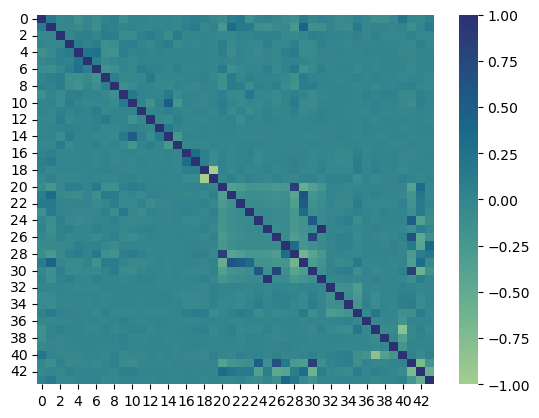

In [63]:
import seaborn as sns
sns.heatmap(pd.DataFrame(x).corr(), cmap='crest')

### Compute horizons at which we evaluate the performance of NSC

Survival predictions are issued at certain time horizons. Here we will evaluate the performance
of NSC to issue predictions at the 25th, 50th and 75th event time quantile as is standard practice in Survival Analysis.

In [47]:
import numpy as np
import torch
np.random.seed(42)
torch.random.manual_seed(42)

horizons = [0.25, 0.5, 0.75]
times = np.quantile(t[e!=0], horizons).tolist()

In [48]:
# Display the percentage of observed event at different time horizon
for time in times:
    print('At time {:.2f}'.format(time))
    for risk in np.unique(e):
        print('\t {:.2f} % observed risk {}'.format(100 * ((e == risk) & (t < time)).mean(), risk))

At time 14.00
	 0.00 % observed risk 0
	 16.71 % observed risk 1
At time 58.00
	 0.00 % observed risk 0
	 33.96 % observed risk 1
At time 252.00
	 0.00 % observed risk 0
	 51.03 % observed risk 1


### Splitting the data into train, test and validation sets

We will train NSC on 80% of the Data (10 % of which is used for stopping criterion and 10% for model Selection) and report performance on the remaining 20% held out test set.

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

x_train, x_test, t_train, t_test, e_train, e_test = train_test_split(x, t, e, test_size = 0.2, random_state = 42)
x_train, x_val, t_train, t_val, e_train, e_val = train_test_split(x_train, t_train, e_train, test_size = 0.2, random_state = 42)
x_dev, x_val, t_dev, t_val, e_dev, e_val = train_test_split(x_val, t_val, e_val, test_size = 0.5, random_state = 42)

minmax = lambda x: x / t_train.max() # Enforce to be inferior to 1
t_train_ddh = minmax(t_train)
t_dev_ddh = minmax(t_dev)
t_val_ddh = minmax(t_val)
times_ddh = minmax(np.array(times))

### Setting the parameter grid

Lets set up the parameter grid to tune hyper-parameters. We will tune the number of underlying survival distributions, 
($K$), the latent representation, the learning rate for the Adam optimizer and the number of hidden layers and nodes.

In [50]:
from sklearn.model_selection import ParameterSampler

In [51]:
layers = [[50], [50, 50], [50, 50, 50], [100], [100, 100], [100, 100, 100]]
param_grid = {
            'learning_rate' : [1e-3, 1e-4],
            'layers_surv': layers,
            'k': [2, 3, 4, 5],
            'representation': [50, 100],
            'layers' : layers,
            'act': ['Tanh'],
            'batch': [100, 250],
            }
params = ParameterSampler(param_grid, 10, random_state = 42)

### Model Training and Selection

In [52]:
from nsc import NeuralSurvivalCluster

In [53]:
models = []
for param in params:
    model = NeuralSurvivalCluster(layers = param['layers'], 
                                  act = param['act'], 
                                  k = param['k'],
                                  layers_surv = param['layers_surv'], 
                                  representation = param['representation'])
    # The fit method is called to train the model
    model.fit(x_train, t_train_ddh, e_train, 
              n_iter = 10, 
              bs = param['batch'],
              lr = param['learning_rate'], 
              val_data = (x_dev, t_dev_ddh, e_dev))
    nll = model.compute_nll(x_val, t_val_ddh, e_val)
    if not(np.isnan(nll)):
        models.append([nll, model])
    else:
        print("WARNING: Nan Value Observed")

Loss: -0.157: 100%|█████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


In [54]:
best_model = min(models, key = lambda x: x[0])
model = best_model[1]

### Inference

Model prediction for the different patients and analysis of the results

In [55]:
out_risk = model.predict_risk(x_test, times_ddh.tolist())
out_survival = model.predict_survival(x_test, times_ddh.tolist())

### Evaluation

We evaluate the performance of NSC in its discriminative ability (Time Dependent Concordance Index and Cumulative Dynamic AUC) as well as Brier Score.

In [56]:
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

In [57]:
et_train = np.array([(e_train[i] == 1, t_train[i]) for i in range(len(e_train))],
                 dtype = [('e', bool), ('t', float)])
et_test = np.array([(e_test[i] == 1, t_test[i]) for i in range(len(e_test))],
                 dtype = [('e', bool), ('t', float)])
selection = (t_test < t_train.max()) | (e_test == 0)

cis = []
for i, _ in enumerate(times):
    cis.append(concordance_index_ipcw(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
brs = brier_score(et_train, et_test[selection], out_survival[selection], times)[1]
roc_auc = []
for i, _ in enumerate(times):
    roc_auc.append(cumulative_dynamic_auc(et_train, et_test[selection], out_risk[:, i][selection], times[i])[0])
for horizon in enumerate(horizons):
    print(f"For {horizon[1]} quantile,")
    print("TD Concordance Index:", cis[horizon[0]])
    print("Brier Score:", brs[horizon[0]])
    print("ROC AUC ", roc_auc[horizon[0]][0], "\n")

For 0.25 quantile,
TD Concordance Index: 0.739823577959035
Brier Score: 0.13292832375032174
ROC AUC  0.7505383252104563 

For 0.5 quantile,
TD Concordance Index: 0.6903909116143121
Brier Score: 0.19859609050921634
ROC AUC  0.7092987262018902 

For 0.75 quantile,
TD Concordance Index: 0.6757568675566982
Brier Score: 0.2152699301019774
ROC AUC  0.7175734034596732 



## Cluster analysis

In this section, we display the learnt clusters and the impact of the different features on the membership to each cluster. This importance is obtained through permutation of the feature.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
times_cluster = np.quantile(t, np.linspace(0, 1, 100))
clusters = model.survival_cluster(minmax(times_cluster).tolist(), 1)

Text(0, 0.5, 'Time')

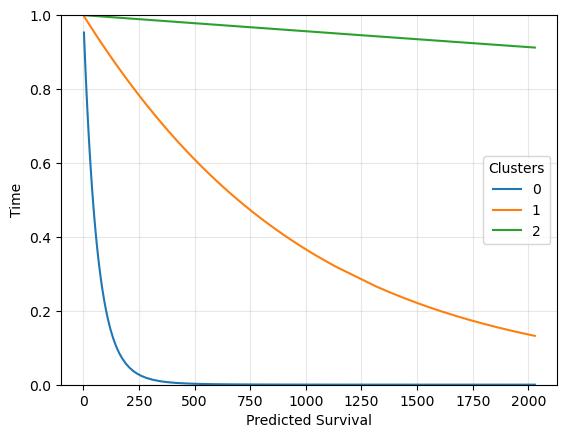

In [60]:
pd.DataFrame(clusters, index = times_cluster).plot()
plt.grid(alpha = 0.3)
plt.ylim(0, 1)
plt.legend(title = 'Clusters')
plt.xlabel('Predicted Survival')
plt.ylabel('Time')

In [61]:
# importance, confidence = model.feature_importance(x_train, t_train_ddh, e_train)

In [62]:
# (pd.DataFrame({'Value': 100 * np.array(list(importance.values())), 'Conf': confidence.values()}, index = columns)).sort_values('Value').plot.bar(yerr = 'Conf')
# plt.ylabel('% change in NLL')
# plt.xlabel('Covariates')
# plt.grid(alpha = 0.3)